In [9]:
### module
import os
import copy

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
from torch.utils.data import DataLoader
import torchvision

from ddpm_conditional import Diffusion
from modules import UNet_conditional
from utils import plot_images
from utils import save_images
from utils import ShapeNetDataset


In [3]:
### args
run_name = "test_epoch_100_view_20_pil"
epochs = 100
batch_size = 13
n_sample = 10

img_size = 64
root_dir = '/home/tfukuda/project/nerf/diffusion_lab/data/diffusion_fix/03001627/'
views = 20

device = "cuda"
lr = 3e-4


In [4]:
### dataloader
def get_data(root_dir, views, batch_size):
    transforms = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(80),  # img_size + 1/4 *img_size
        # torchvision.transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = ShapeNetDataset(root=root_dir, transforms=transforms, views=views)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


In [6]:
### model
device = device
diffusion = Diffusion(img_size=img_size, device=device)
dataloader = get_data(root_dir=root_dir, views=views, batch_size=batch_size)
model = UNet_conditional(img_size=img_size).to(device)

epoch_ini = 110

model_dict = torch.load(os.path.join("models", run_name, f"{epoch_ini}_ckpt.pt"))
model.load_state_dict(model_dict)

ema_model_dict = torch.load(os.path.join("models", run_name, f"{epoch_ini}_ema_ckpt.pt"))

ema_model = copy.deepcopy(model).eval().requires_grad_(False)
ema_model.load_state_dict(ema_model_dict)


<All keys matched successfully>

In [21]:
### input
tmp = dataloader.__iter__()
val_x1, val_x2, val_x1_rot, val_x1_ele, val_x2_rot, val_x2_ele = tmp.next()
val_x1 = val_x1[0].to(device)
val_x2 = val_x2[0].to(device)
val_x1_rot = val_x1_rot[0].to(device)
val_x1_ele = val_x1_ele[0].to(device)
val_x2_rot = val_x2_rot[0].to(device)
val_x2_ele = val_x2_ele[0].to(device)

a = torch.FloatTensor([0.5, 0.5, 0.5]).to(device)
# for x1 in val_x1:
#     x1 *= a.view(3, 1, 1)
#     x1 += a.view(3, 1, 1)
    
# plot_images(val_x1)

origin1 = val_x1.view(3, 64, 64)
origin1 *= a.view(3, 1, 1)
origin1 += a.view(3, 1, 1)
origin2 = val_x2.view(3, 64, 64)
origin2 *= a.view(3, 1, 1)
origin2 += a.view(3, 1, 1)


# cv2.imwrite('sample_x1.png', origin1.cpu().permute(1, 2, 0).numpy() * 255)
# cv2.imwrite('sample_x2.png', origin2.cpu().permute(1, 2, 0).numpy() * 255)

plt.figure()
plt.imshow(origin1.cpu().permute(1, 2, 0))
# plt.imsave('sample_x1.png', (origin1.cpu().permute(1, 2, 0) * 255).long())
plt.figure()
plt.imshow(origin2.cpu().permute(1, 2, 0))
# plt.imsave('sample_x2.png', (origin2.cpu().permute(1, 2, 0) * 255).long())



TypeError: Cannot interpret 'torch.int64' as a data type

<Figure size 640x480 with 0 Axes>

12:41:02 - INFO: Sampling 10 new images....
999it [00:58, 16.93it/s]
12:42:01 - INFO: Sampling 10 new images....
999it [00:59, 16.82it/s]


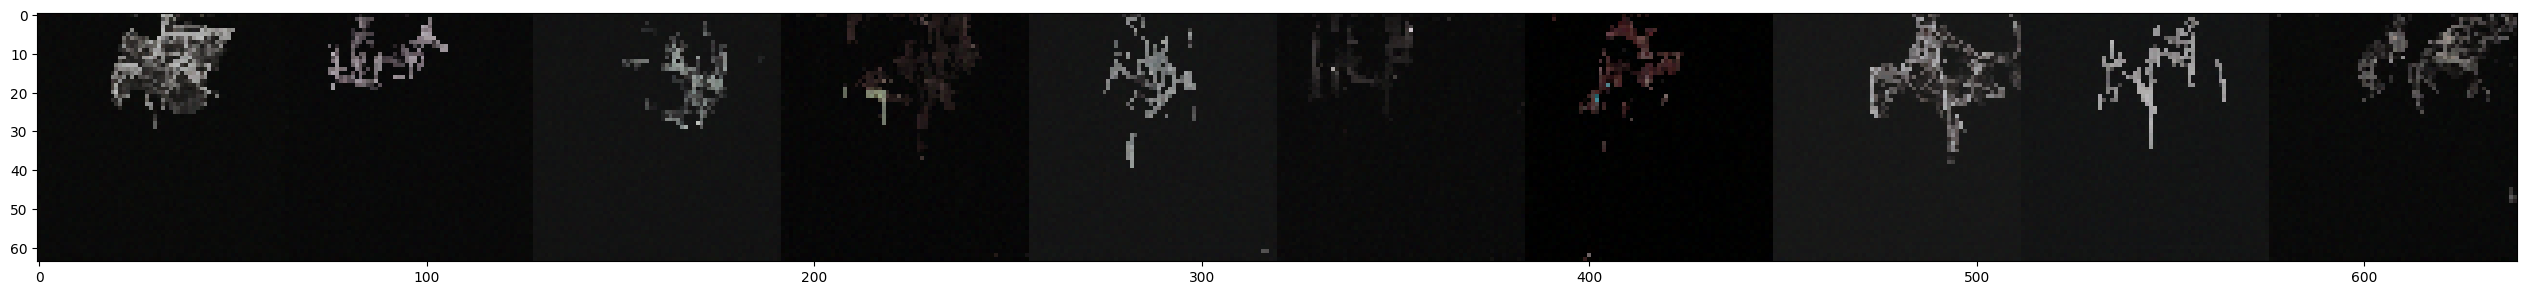

In [48]:
### sampling
sampled_images = diffusion.sample(model, n=n_sample, x2=val_x2, x1_rot=val_x1_rot, x1_ele=val_x1_ele, x2_rot=val_x2_rot, x2_ele=val_x2_ele, cfg_scale=0)
ema_sampled_images = diffusion.sample(ema_model, n=n_sample, x2=val_x2, x1_rot=val_x1_rot, x1_ele=val_x1_ele, x2_rot=val_x2_rot, x2_ele=val_x2_ele, cfg_scale=0)
plot_images(sampled_images)
save_images(sampled_images, os.path.join("sampling", f"sample.jpg"))
save_images(ema_sampled_images, os.path.join("sampling", f"sample_ema.jpg"))


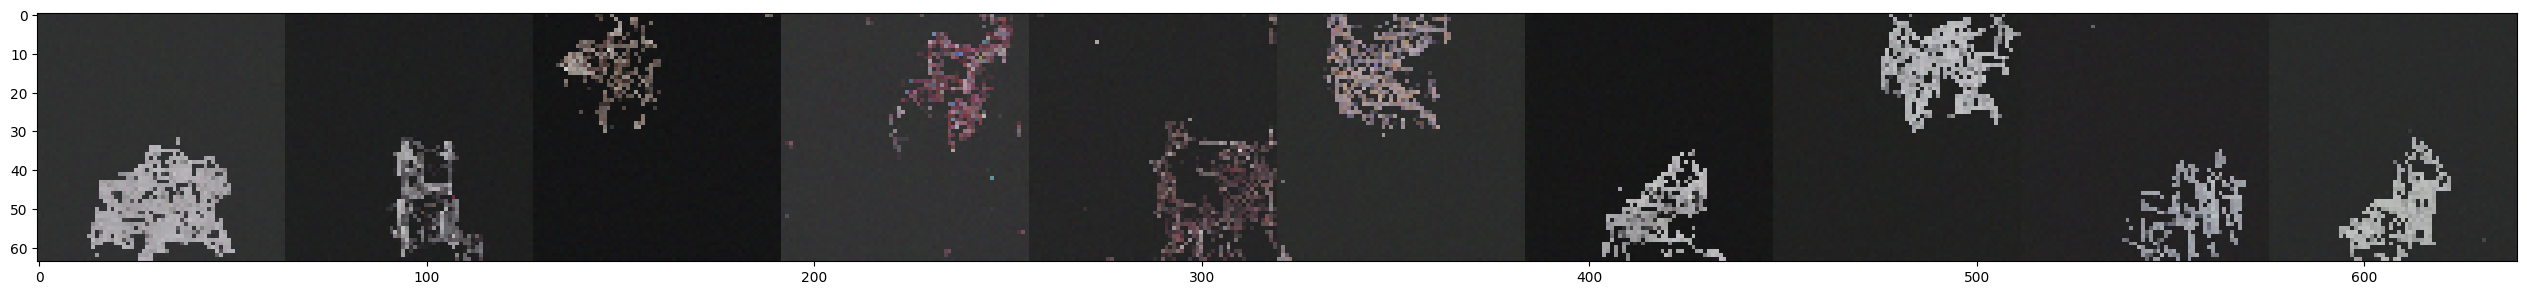

In [49]:
plot_images(ema_sampled_images)
